# HW 4 - Joining, SQL & Regex

##  Joining - pop_data, cellphone_data & country_data
In this assignment, we will clean, format, join multiple tables and do some baisc analysis. First, we will join the cellphone_data from HW3 with the population data to calculate the number of phones per capita. Next, we will refine the tables further by adding the correct country name for each observation using the country_data.

In [132]:
library(tidyverse)
library(ggplot2)
library(patchwork)  
library(GGally)
library(knitr)
library(dplyr)
library(hms)
library(zoo)

pop_data <-  read.csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/pop_data.csv")
cellphone_data <- read.csv("clean_cellphone.csv")

Here is a glimpse of the pop_data:

In [123]:
print("pop_data:")
head(pop_data,caption = "pop_data")

[1] "pop_data:"


,X,iso.3,X1960,X1961,X1962,X1963,X1964,X1965,X1966,X1967,⋯,X2011,X2012,X2013,X2014,X2015,X2016,X2017,X2018,X2019,X2020
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,ABW,54608,55811,56682,57475,58178,58782,59291,59522,⋯,101288,102112,102880,103594,104257,104874,105439,105962,106442,106585
2,1,AFE,130692579,134169237,137835590,141630546,145605995,149742351,153955516,158313235,⋯,537792950,552530654,567892149,583651101,600008424,616377605,632746570,649757148,667242986,685112979
3,2,AFG,8622466,8790140,8969047,9157465,9355514,9565147,9783147,10010030,⋯,29249157,30466479,31541209,32716210,33753499,34636207,35643418,36686784,37769499,38972230
4,3,AFW,97256290,99314028,101445032,103667517,105959979,108336203,110798486,113319950,⋯,366489204,376797999,387204553,397855507,408690375,419778384,431138704,442646825,454306063,466189102
5,4,AGO,5357195,5441333,5521400,5599827,5673199,5736582,5787044,5827503,⋯,24259111,25188292,26147002,27128337,28127721,29154746,30208628,31273533,32353588,33428486
6,5,ALB,1608800,1659800,1711319,1762621,1814135,1864791,1914573,1965598,⋯,2905195,2900401,2895092,2889104,2880703,2876101,2873457,2866376,2854191,2837849


## Cleaning
First, we need to clean the pop_data. It isn't very messy, but the first column is unnecessary, there are some NA values, and since the cellphone data had its first recorded cellphone count in 1980, we exclude all data before that year.

My first thought was to filter away countries with a proportion of NA's above some threshold, but after some analysis, I realized there are only two rows with NA values. INX has all its values as NA, and PSE has a large portion of the first years as NA. We exclude INX from our data. After further analysis, we observe that the population growth trend is clearly linear, see figure 1. Therefore, we use linear interpolation to fill in the NA values.  

We can see the two problematic rows here down below:

In [133]:
#relevant years
cellphone_data <- cellphone_data %>% 
  select(-X1979)

pop_data_relavent_years <- pop_data %>% 
  select(-c(X1960:X1979))

#finding rows with NA-proportion > 1%, i.e one or more NA
poor_rows <- c() # collect 'bad' rows
for(i in seq(nrow(pop_data_relavent_years))){
  row <- pop_data_relavent_years[i,-c(1,2)]
  number_of_na <- length(which(is.na(row)))
  proportio_of_na <- number_of_na/length(row)
  if(proportio_of_na>0.01){
    poor_rows <- c(poor_rows,i)
  }
}

#rows with NA's 
print('Problematic rows')
pop_data_relavent_years[poor_rows,]


[1] "Problematic rows"


,X,iso.3,X1980,X1981,X1982,X1983,X1984,X1985,X1986,X1987,⋯,X2011,X2012,X2013,X2014,X2015,X2016,X2017,X2018,X2019,X2020
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
111,110,INX,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
197,196,PSE,NA,NA,NA,NA,NA,NA,NA,NA,⋯,3882986,3979998,4076708,4173398,4270092,4367088,4454805,4569087,4685306,4803269


Here in figure 1 we can see the linear trend in population of Country "PSE":

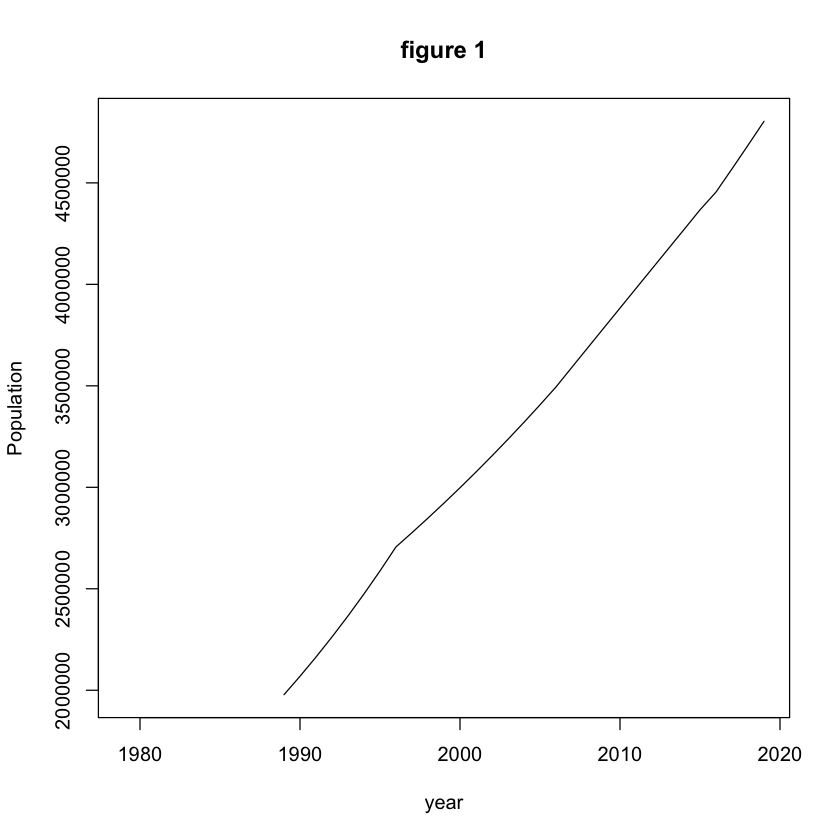

In [139]:
PSE <- as.matrix(pop_data_relavent_years[197,-c(1,2)])
plot(seq(1979,2019,by=1),type = 'l',PSE,main = "figure 1",xlab = "year",ylab="Population")

In [126]:
# Filling in NA's in PSE row with linear regression
non_na_indices <- which(!is.na(PSE))
non_na_values <- PSE[non_na_indices]
model <- lm(non_na_values ~ non_na_indices)
na_indices <- which(is.na(PSE))
PSE[na_indices] <- predict(model, newdata = data.frame(non_na_indices = na_indices))

#adding the interpolated vector
pop_data_relavent_years[197,-c(1,2)] <- PSE

#excluding INX and first column (indexing-column)
pop_data_cleaned <- pop_data_relavent_years %>% 
  filter(iso.3 != "INX") %>% 
  select(-1)

## Formating
Before we are ready to join these to cleaned tables, we must change the format with pivot_longer(): 

In [127]:
pop_data_longer <- pop_data_cleaned %>% 
  pivot_longer(
     cols = starts_with("X"),      
     names_to = "Year",             
     values_to = "Population"  
  )

cellphones_longer <- cellphone_data %>% 
  pivot_longer(
     cols = starts_with("X"),       
     names_to = "Year",             
     values_to = "Cellphones"  
  )

## Joining
Now we are ready to join the two tables. We can see the first joining-result in table 1.

In [140]:
#joining
joined_df <- cellphones_longer %>%
  left_join(pop_data_longer,by=c("Year","iso.3"))

#year as numeric
joined_df <- joined_df %>%
  mutate(Year = as.numeric(str_remove(Year, "X"))) %>% 
  arrange(Year)

kable(head(joined_df),caption = "1")



Table: 1

|iso.3 | Year| Cellphones| Population|
|:-----|----:|----------:|----------:|
|ABW   | 1980|          0|      62267|
|AFG   | 1980|          0|   12486631|
|AGO   | 1980|          0|    8330047|
|ALB   | 1980|          0|    2671997|
|AND   | 1980|          0|      35611|
|ARE   | 1980|          0|    1014048|

The next step is to ensure that each row has a corresponding country name matching the iso.3 ID. The one-to-one correspondence between Country and iso.3 can be found in the country_data.csv. We then combine the cellphone, population, and country data into a single table and calculate the number of phones per capita. Table 2 shows the countries with the highest number of phones per capita in the year 2019.

In [129]:
country_data <- read.csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/country_data.csv")

#select the country-column and iso.3-column(which here is called aplha.3)
relevant_columns <- country_data %>% 
  select(name,alpha.3) %>% 
  transmute(name = name, iso.3 = alpha.3)

# match country names iso.3 and order by highest cellphone per capital and year
cellphones_per_captila_ordered <- joined_df %>% 
  left_join(relevant_columns,by = "iso.3") %>% 
  select(-iso.3) %>% 
  mutate(cellphones_pc = Cellphones/Population) %>% 
  select(name,Year,cellphones_pc) %>% 
  group_by(name) %>% 
  arrange(desc(Year),desc(cellphones_pc)) 

# back to prefered format (pivot wider) & ordered by highest cpc
highest_cpc <- cellphones_per_captila_ordered %>%
  pivot_wider(
  names_from=name,
  values_from=cellphones_pc) %>% 
  select(Year:Seychelles) %>% 
  filter(Year >=2015) %>% 
  arrange(Year)

kable(highest_cpc,caption = 2)



Table: 2

| Year|    Macao| Hong Kong| United Arab Emirates| Antigua and Barbuda| Seychelles|
|----:|--------:|---------:|--------------------:|-------------------:|----------:|
| 2015| 3.088231|  2.290401|             2.007424|            1.956838|   1.584260|
| 2016| 3.143510|  2.398931|             2.212521|            1.987545|   1.605459|
| 2017| 3.210102|  2.488774|             2.183431|            2.019337|   1.742433|
| 2018| 3.348741|  2.670209|             2.199084|            2.008164|   1.849900|
| 2019| 3.284849|  2.863650|             2.127739|            1.997460|   1.987196|

## Plotting the growth rate
Next we are creating a plot that illustrates the growth rate of the countries in the table above over the last 10 years, se figure 2. We can see that something might have gone wrong with the interpolation of the cellphone_data. Antigua and Barbuda seems to have a significant drop in phone per capita year 2012, 2013 & 2014. It might be a good idea to review the interpolation. But since that's not the focus, we will skip it for now. 

(I have to admit that I'm a bit confused about which dataset we should plot here. The table referred to in the assignment only includes the countries with the highest phones per capita in 2019. However, the countries with the highest (linear) growth rate in phones per capita are a completely different set of countries.)

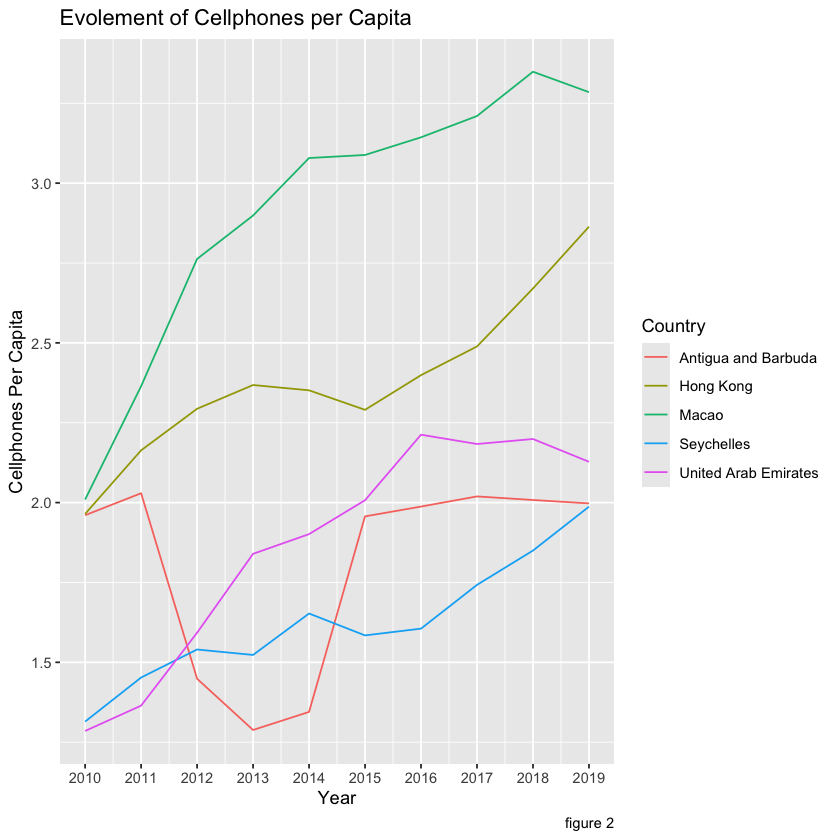

In [152]:
relevant_for_analysis <- cellphones_per_captila_ordered %>%
  pivot_wider(
  names_from=name,
  values_from=cellphones_pc) %>% 
  select(Year:Seychelles) %>% 
  filter(Year >=2010) %>% 
  arrange(Year) %>% 
  pivot_longer(
    cols = -Year,
    names_to = 'Country',
    values_to = "cpc")

ggplot(relevant_for_analysis,aes(x=Year, y=cpc, color = Country))+
  geom_line()+
   scale_x_continuous(breaks = 2010:2019,labels = 2010:2019)+
  labs(
      title = "Evolement of Cellphones per Capita",
      x="Year",
      y= "Cellphones Per Capita",
      caption="figure 2")


## SQL - user_action.db
Now we are going to analyze the user_actions table in user_actions.db using SQL to retrieve some specific information.  
First we take a short look at the table user_actions:

In [141]:
library(DBI)
library(RSQLite)

#conect to user_actions data-base
con <- dbConnect(SQLite(), dbname = "user_actions.db")
# 
data <- dbGetQuery(con,"SELECT * FROM user_actions")
head(data)

,user_id,username,email,action,timestamp
,<int>,<chr>,<chr>,<chr>,<chr>
1,34,user34,user34@email.com,signup,2015-02-04 14:38:47
2,28,user28,user28@email.com,signup,2015-03-09 11:55:33
3,27,user27,user27@email.com,login,2015-04-17 14:48:31
4,27,user27,user27@email.com,login,2015-04-21 13:22:14
5,27,user27,user27@email.com,reset_password,2015-04-25 16:30:15
6,27,user27,user27@email.com,login,2015-05-31 15:58:20


Now we retrieve the usernames of all users who have performed the "signup" action:

In [32]:
query1 <- 
"
SELECT username, action
FROM user_actions
WHERE action == 'signup' 
"
signups <- dbGetQuery(con,query1)
head(signups)

,username,action
,<chr>,<chr>
1,user34,signup
2,user28,signup
3,user1,signup
4,user24,signup
5,user15,signup
6,user20,signup


Here we find the total number of log entries for each user displaying the the user_id, username, and the count of log entries:

In [156]:
query2 <- "
SELECT user_id,username, COUNT(timestamp) AS [Logins]
FROM user_actions
GROUP BY username
"
log_entries <- dbGetQuery(con,query2)
head(log_entries)

,user_id,username,Logins
,<int>,<chr>,<int>
1,1,user1,104
2,10,user10,170
3,11,user11,328
4,12,user12,209
5,13,user13,470
6,14,user14,320


Lastly we identify users who have both logged in and signed up on the same day, displaying the user_id and username:

In [31]:
query3 <- "
SELECT user_id, username
FROM user_actions
WHERE action IN ('signup', 'login')
GROUP BY user_id, username, DATE(timestamp)
HAVING COUNT(DISTINCT action) = 2
"
login_and_signup <- dbGetQuery(con,query3)
head(login_and_signup)

,user_id,username
,<int>,<chr>
1,2,user2
2,5,user5
3,7,user7
4,8,user8
5,12,user12
6,22,user22


## Regex - comments.txt
In this section we are going to analyze the comments.txt file to extract information using regex. 

We start off by extracting all the hashtags of each comments. Two examples of this operation are shown down below.

In [144]:
library(stringr)
#read in comments
comments <- readLines("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/comments.txt")


#match all hashtags
#--------------
#regular expression
pattern1 = "#\\w+"  #starts with # followed by atleast 1 alphabetic charcter

#test-comments
comment1 <- "Great post! #programming #tips"
comment2 <- "Enjoyed the article. #coding #python"

# collecting hashtags
hashtags_comment1 <- unlist(str_extract_all(comment1,pattern1))
hashtags_comment2 <- unlist(str_extract_all(comment2,pattern1))

# print hashtags in comment 1 & 2
cat("Hashtags in comment-1: ",paste(hashtags_comment1,collapse = ", "),"\n")
cat("Hashtags in comment-2: ",paste(hashtags_comment2,collapse = ", "),"\n")


Hashtags in comment-1:  #programming, #tips 
Hashtags in comment-2:  #coding, #python 


Now we create a regular expression to find comments that mention both "#programming" and "#python. We also include two examples:

In [146]:

#find hashtags #programming & #pyton
#-------------------------------------

pattern2 = "#p\\w*"   # startwith #p followed by any alphabetic characters

#test pattern
pyton_hashtag_in_comment2 <- unlist(str_extract_all("Enjoyed the article. #coding #python",pattern2))
programming_and_pyton_hashtag_in_comment15 <- unlist(str_extract_all("Well explained. #programming #python #tips",pattern2))

cat("Programming-hashtag is in comment-2: ",pyton_hashtag_in_comment2,"\n")
cat("Pyton-hashtag is in comment-15: ",programming_and_pyton_hashtag_in_comment15,"\n")


Programming-hashtag is in comment-2:  #python 
Pyton-hashtag is in comment-15:  #programming #python 


In [ ]:
We can use pattern1 to capture all the unique hashtags:

In [148]:
pattern1 = "#\\w+"  #starts with #followed by atleast 1 alphabetic charcter
hashtags1 <- str_extract_all(comments,pattern1)
#all unique hashtags
unique(unlist(hashtags1))

[1] "#programming" "#tips"        "#coding"      "#python"      "#tech"       
 [6] "#data"        "#analysis"    "#innovation"  "#analytics"   "#insights"   
[11] "#research"